In [ ]:
%pip install segments-ai 

In [ ]:
%git clone https://github.com/CChristenson1/Mask_RCNN.git

In [4]:
import os
import sys
import os.path as osp
import json
import numpy as np
import skimage.io
import datetime
from PIL import Image
from argparse import ArgumentParser
from skimage.measure import regionprops
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [5]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist.'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.config import Config


##Dataset

In [6]:
VAL_IMAGE_IDS = []
LIST_IMAGE_IDS = []
class MaizeDataset(utils.Dataset):
    def load_maize(self, dataset_dir, subset):

        # Add the class names using the base method from utils.Dataset
        """Implement way to add class_ids from dataset"""
        self.add_class("Maize", 1, "kernel")
        self.add_class("Maize", 2, "cob")
        # self.add_class("Maise", 3, "aborted kernel")

        # Get filenames and annotation
        filenames = next(os.walk(dataset_dir))[2]
        annotation_filename = [
            filename for filename in filenames if filename.split(".")[1] == "json"
        ][0]

        # Which subset?
        # "val":
        # "train":
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val", "test", "list"]
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        elif subset == "list":
            image_ids = LIST_IMAGE_IDS
        else:
            image_ids = [
                filename.split(".")[0]
                for filename in filenames
                if (
                    (not filename.split("_")[-1] in ["ground-truth.png", "label.png"])
                    and (filename.split(".")[1] == "png")
                )
            ]
        if subset == "train":
            image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))

        annotation_json = osp.join(dataset_dir, annotation_filename)
        with open(annotation_json) as f:
            annotations = json.load(f)

        # Add images
        for image_id in image_ids:
            image = image_id + ".png"
            # Get class ids
            class_ids = []
            for annotation in annotations:
                if annotation["image_name"] == image_id:
                    class_ids = annotation["class_ids"]

            self.add_image(
                "Maize",
                image_id=image_id,
                path=os.path.join(dataset_dir, image),
                class_ids=class_ids,
            )

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        image_name = info["id"]
        bitmap_path = str
        if osp.exists(osp.join((osp.dirname(info["path"])), f"{image_name}_label.png")):
            bitmap_path = osp.join(
                (osp.dirname(info["path"])), f"{image_name}_label.png"
            )
        elif osp.exists(
            osp.join(
                (osp.dirname(info["path"])), f"{image_name}_label_ground-truth.png"
            )
        ):
            bitmap_path = osp.join(
                (osp.dirname(info["path"])), f"{image_name}_label_ground-truth.png"
            )
        else:
            print(
                "Image labels must have the form *_label.png or *_label-ground-truth.png"
            )
            SystemExit()

        instances = info["class_ids"]
        # Read mask files from .png image
        mask = []
        class_ids = []
        bitmap = skimage.io.imread(bitmap_path)
        for instance in instances:
            if instance["class_id"] in self.class_ids:
                m = np.array(bitmap, np.uint32) == instance["id"]
                m.astype(bool)
                mask.append(m)
                class_ids.append(instance["class_id"])
            else:
                continue
        mask = np.stack(mask, axis=-1)
        class_ids = np.asarray(class_ids, dtype=np.int32)

        # Return mask, and array of class IDs of each instance.
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "Maize":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

## Image prep 

In [ ]:
if not osp.exists("../datasets"):
  os.mkdir("../datasets")
%python maize/image_prep.py API_KEY v0.3 -o ../datasets/full  -d Cchristenson3/Maize_Images reviewed -c 1,2 

#Feature Extraction

**Desired Features:**
<li> Kernel Dimensions (height, width)
<li> Kernel Count
<li> Row Count
<li> Column Count
<li> Percent Ear Fill

**Methods**
<li> Use annotations and label.png 
<li> Have dataset of kernels

###Utils

In [8]:
import matplotlib.pyplot as plt

In [9]:
def visualize_stack(images):
    shape = np.shape(images)
    cimage = np.zeros((shape[1],shape[2]))
    for image in images:
        cimage += image
        plt.imshow(np.array(cimage))
        plt.show()

In [10]:
def percent_ear_fill(image_masks,class_ids):
    """Calculate ear fill given the image_masks and class_ids"""
    total_masked = np.sum(image_masks)
    kernel_masked = 0
    for image_mask, class_id in zip(image_masks, class_ids):
        if class_id == 1:
            kernel_masked += np.sum(image_mask)

    percent_ear_fill = (kernel_masked / total_masked)*100
    return percent_ear_fill

In [11]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

In [28]:
def build_location_index(bboxes, masks):
    """Builds list of kernel ids sorted based on location top left->top right"""
    location_array = []
    for id, bbox in enumerate(bboxes):
        x, y = bbox[0], bbox[1]
        location_array.append([id, x, y, bbox, masks[:,:,id]])
    slocation_array = sorted(location_array, key=lambda k: [k[1], k[2]])
    position_id = 1
    location_index = []
    for kernel in slocation_array:
        kernel_dict = {
            "id": kernel[0],
            "position_id":position_id,
            "bbox": kernel[3],
            "mask": kernel[4]
        }
        location_index.append(kernel_dict)
        position_id +=1

    return location_index

In [22]:
def get_row_count(location_index):
    """Determine the number of kernels per row and the number of rows"""
    updated_index = []
    kernel_per_row = []
    st_bbox = location_index[0]['bbox']
    row_num = 1
    kernel_num = 1
    for kernel in location_index:    
        bbox=kernel['bbox']
        mid_point = int((bbox[0] + bbox[2]) / 2)
        if mid_point in range(st_bbox[0], st_bbox[2]):
            kernel.update({ 
                "row": row_num                                   
             })
            kernel_num +=1
        else: 
            row_num +=1
            st_bbox = kernel["bbox"]
            kernel_per_row.append(kernel_num)
            kernel_num =1
            kernel.update({
                "row": row_num
            })

        updated_index.append(kernel)

    return row_num, kernel_per_row, updated_index

###Executables

Image name: 1810_2_1203 
 Percent Ear Fill: 36.08347506186176 
 Number of Kernels: 171 
 Number of Rows: 18 
 Number of Kernels Per Row: 25


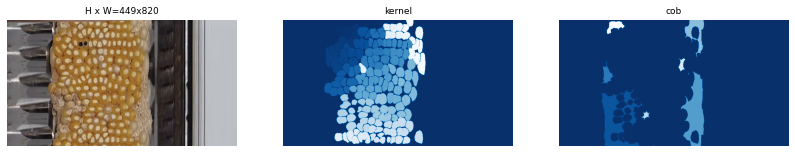

Image name: 1806_3_1203 
 Percent Ear Fill: 74.91284939469944 
 Number of Kernels: 340 
 Number of Rows: 18 
 Number of Kernels Per Row: 30


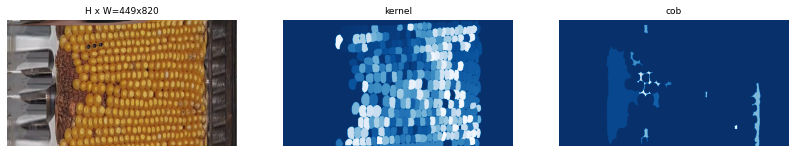

Image name: 1817_2_1203 
 Percent Ear Fill: 81.87116329554615 
 Number of Kernels: 371 
 Number of Rows: 21 
 Number of Kernels Per Row: 42


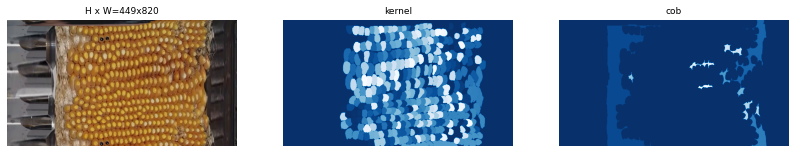

Image name: 1400_1_1203 
 Percent Ear Fill: 57.78798786255697 
 Number of Kernels: 244 
 Number of Rows: 21 
 Number of Kernels Per Row: 21


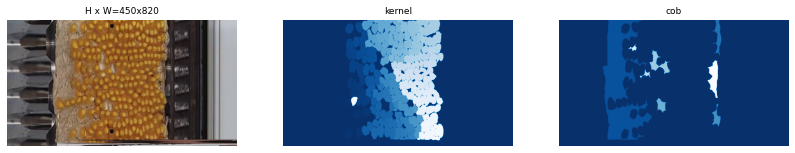

[{'Image name': '1810_2_1203', 'Percent Ear Fill': 36.08347506186176, 'Number of Kernels': 171, 'Number of Rows': 18, 'Number of Kernels Per Row': 25}, {'Image name': '1806_3_1203', 'Percent Ear Fill': 74.91284939469944, 'Number of Kernels': 340, 'Number of Rows': 18, 'Number of Kernels Per Row': 30}, {'Image name': '1817_2_1203', 'Percent Ear Fill': 81.87116329554615, 'Number of Kernels': 371, 'Number of Rows': 21, 'Number of Kernels Per Row': 42}, {'Image name': '1400_1_1203', 'Percent Ear Fill': 57.78798786255697, 'Number of Kernels': 244, 'Number of Rows': 21, 'Number of Kernels Per Row': 21}]


In [15]:
dataset_dir = "/content/Mask_RCNN/datasets/full/Cchristenson3_Maize_Images/v0.3"
feature_dataset = MaizeDataset()
feature_dataset.load_maize(dataset_dir, "train")
feature_dataset.prepare()

image_ids = np.random.choice(feature_dataset.image_ids, 4)

generated_data = []
for image_id in image_ids:
    image = feature_dataset.load_image(image_id)
    image_name = feature_dataset.image_info[image_id]["id"]
    masks, class_ids = feature_dataset.load_mask(image_id)

    ear_fill = percent_ear_fill(masks,class_ids)
    masks = masks.swapaxes(0,2)

    kernel_masks = np.array([mask for mask, class_id in zip(masks,class_ids) if class_id == 1])
    masks = masks.swapaxes(0,2)
    kernel_masks = kernel_masks.transpose()

    kernel_count = (kernel_masks.shape[2])

    kernel_bboxes = extract_bboxes(kernel_masks)
  
    row_index = build_location_index(kernel_bboxes, kernel_masks)    

    row_count, kernel_per_row, u_location_index = get_row_count(row_index)
    column_count = np.max(kernel_per_row)
    
    
    generated_data.append({"Image name": image_name, "Percent Ear Fill": ear_fill, "Number of Kernels": kernel_count, "Number of Rows": row_count,  "Number of Kernels Per Row": column_count})
    print(f"Image name: {image_name} \n Percent Ear Fill: {ear_fill} \n Number of Kernels: {kernel_count} \n Number of Rows: {row_count} \n Number of Kernels Per Row: {column_count}")
    visualize.display_top_masks(image, masks, class_ids, feature_dataset.class_names, limit=2)
print(generated_data)

##Testing Row Extraction

In [ ]:
image_ids = np.random.choice(feature_dataset.image_ids, 1)

for image_id in image_ids:
    print(image_id)
    image = feature_dataset.load_image(image_id)
    masks, class_ids = feature_dataset.load_mask(image_id)
    masks = masks.swapaxes(0,2)
    kernel_masks = np.array([mask for mask, class_id in zip(masks,class_ids) if class_id == 1])
    masks = masks.swapaxes(0,2)
    kernel_masks = kernel_masks.transpose()

    
    bboxes = extract_bboxes(kernel_masks)

    row_index = build_location_index(bboxes, kernel_masks)   
    
   
    #row_imask = np.array([kernel["mask"] for kernel in row_index])
    row_count, kernel_per_row, u_location_index = get_row_count(row_index)

    row_imask = np.array([kernel["mask"] for kernel in u_location_index])


    print(f"Image name: {image_name} \n Number of Kernels: {kernel_count} \n Number of Rows: {row_count} \n Number of Kernels Per Row: {kernel_per_row}")
    visualize.display_top_masks(image, masks, class_ids, feature_dataset.class_names, limit=2)

    print(kernel_masks.shape)
    kernel_masks = kernel_masks.transpose()
    kernel_masks= kernel_masks.swapaxes(1,2)
    print(kernel_masks.shape)
    visualize_stack(kernel_masks)
    #visualize_stack(row_imask)
    